In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Fri Jan 12 17:20:29 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   24C    P8    14W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_vae_encoder import Encoder
from model.latent_layer.sampling_uniform_lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.0202789306640625
encoder.convs 5.989013671875
encoder.linear 0.0312652587890625
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.12-9/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 37572
-rw-rw-r-- 1 scpark scpark   192932  1월 12 17:20 events.out.tfevents.1705047511.GPUSVR01
-rw-rw-r-- 1 scpark scpark 38023101  1월 12 17:18 save_0
-rw-rw-r-- 1 scpark scpark   252356  1월 12 17:18 events.out.tfevents.1705047349.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


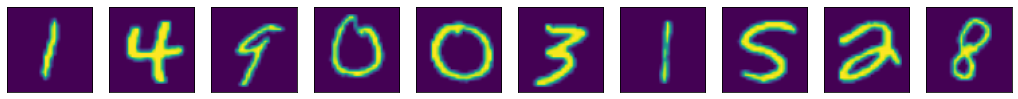

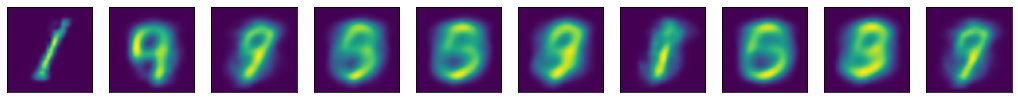

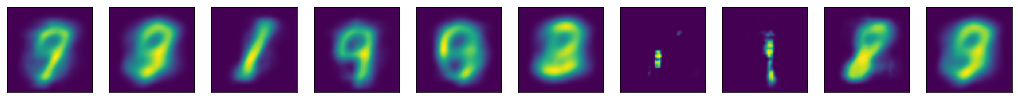

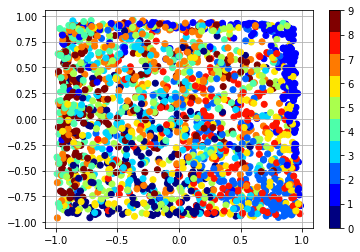

107001
lse_loss 12.636106491088867
recon_loss 0.1852821409702301
107002
lse_loss 12.329930305480957
recon_loss 0.18156683444976807
107003
lse_loss 12.101791381835938
recon_loss 0.19551114737987518
107004
lse_loss 11.99397087097168
recon_loss 0.1923983097076416
107005
lse_loss 12.404861450195312
recon_loss 0.19608263671398163
107006
lse_loss 13.434202194213867
recon_loss 0.1825433224439621
107007
lse_loss 12.430244445800781
recon_loss 0.179144486784935
107008
lse_loss 11.475971221923828
recon_loss 0.19551369547843933
107009
lse_loss 11.335028648376465
recon_loss 0.1972501277923584
107010
lse_loss 12.83056640625
recon_loss 0.1982341706752777
107011
lse_loss 13.575583457946777
recon_loss 0.18224763870239258
107012
lse_loss 11.741896629333496
recon_loss 0.19191738963127136
107013
lse_loss 11.374772071838379
recon_loss 0.19248728454113007
107014
lse_loss 13.128057479858398
recon_loss 0.20615720748901367
107015
lse_loss 12.354999542236328
recon_loss 0.1830819547176361
107016
lse_loss 12.2119

107129
lse_loss 12.660944938659668
recon_loss 0.1990024447441101
107130
lse_loss 12.508241653442383
recon_loss 0.1802571713924408
107131
lse_loss 13.316662788391113
recon_loss 0.18224088847637177
107132
lse_loss 11.795015335083008
recon_loss 0.19457873702049255
107133
lse_loss 14.360567092895508
recon_loss 0.18377089500427246
107134
lse_loss 14.442928314208984
recon_loss 0.18736624717712402
107135
lse_loss 12.154875755310059
recon_loss 0.1795174777507782
107136
lse_loss 14.543744087219238
recon_loss 0.18971896171569824
107137
lse_loss 13.540897369384766
recon_loss 0.1883789598941803
107138
lse_loss 12.980278015136719
recon_loss 0.19106006622314453
107139
lse_loss 13.813071250915527
recon_loss 0.2060070037841797
107140
lse_loss 12.309303283691406
recon_loss 0.18757787346839905
107141
lse_loss 11.602043151855469
recon_loss 0.18626956641674042
107142
lse_loss 12.131185531616211
recon_loss 0.18047472834587097
107143
lse_loss 13.920806884765625
recon_loss 0.1910531222820282
107144
lse_loss 

107257
lse_loss 12.515419006347656
recon_loss 0.19953207671642303
107258
lse_loss 11.845389366149902
recon_loss 0.17968159914016724
107259
lse_loss 11.820143699645996
recon_loss 0.1976555585861206
107260
lse_loss 13.270527839660645
recon_loss 0.19092534482479095
107261
lse_loss 13.249467849731445
recon_loss 0.2030492126941681
107262
lse_loss 14.0394868850708
recon_loss 0.18402838706970215
107263
lse_loss 12.093889236450195
recon_loss 0.19431529939174652
107264
lse_loss 15.122641563415527
recon_loss 0.17384308576583862
107265
lse_loss 13.666084289550781
recon_loss 0.19186878204345703
107266
lse_loss 12.933553695678711
recon_loss 0.1776229590177536
107267
lse_loss 10.99547004699707
recon_loss 0.20052151381969452
107268
lse_loss 12.659035682678223
recon_loss 0.18017920851707458
107269
lse_loss 13.705211639404297
recon_loss 0.18990442156791687
107270
lse_loss 12.275867462158203
recon_loss 0.19146093726158142
107271
lse_loss 13.251496315002441
recon_loss 0.18931633234024048
107272
lse_loss 

107383
lse_loss 11.517683982849121
recon_loss 0.18801388144493103
107384
lse_loss 14.545409202575684
recon_loss 0.18866197764873505
107385
lse_loss 11.895691871643066
recon_loss 0.19225989282131195
107386
lse_loss 13.456732749938965
recon_loss 0.19371750950813293
107387
lse_loss 13.217499732971191
recon_loss 0.19716159999370575
107388
lse_loss 12.750100135803223
recon_loss 0.19841179251670837
107389
lse_loss 14.481588363647461
recon_loss 0.19763147830963135
107390
lse_loss 12.643818855285645
recon_loss 0.19368624687194824
107391
lse_loss 13.72536849975586
recon_loss 0.18379956483840942
107392
lse_loss 15.32541275024414
recon_loss 0.17388591170310974
107393
lse_loss 15.984928131103516
recon_loss 0.18053226172924042
107394
lse_loss 12.791619300842285
recon_loss 0.18969079852104187
107395
lse_loss 12.76763916015625
recon_loss 0.19152824580669403
107396
lse_loss 11.964998245239258
recon_loss 0.1900147646665573
107397
lse_loss 12.390571594238281
recon_loss 0.19101254642009735
107398
lse_los

107508
lse_loss 14.290637016296387
recon_loss 0.18706616759300232
107509
lse_loss 12.531834602355957
recon_loss 0.1878707855939865
107510
lse_loss 13.492070198059082
recon_loss 0.19748210906982422
107511
lse_loss 12.784016609191895
recon_loss 0.19017279148101807
107512
lse_loss 12.528616905212402
recon_loss 0.1907854527235031
107513
lse_loss 13.241580963134766
recon_loss 0.19306914508342743
107514
lse_loss 12.224122047424316
recon_loss 0.1902279555797577
107515
lse_loss 14.823826789855957
recon_loss 0.20670120418071747
107516
lse_loss 13.281624794006348
recon_loss 0.1868395060300827
107517
lse_loss 13.597247123718262
recon_loss 0.18179504573345184
107518
lse_loss 14.259297370910645
recon_loss 0.19014209508895874
107519
lse_loss 13.753107070922852
recon_loss 0.18345263600349426
107520
lse_loss 18.05746078491211
recon_loss 0.18914835155010223
107521
lse_loss 13.625419616699219
recon_loss 0.19277402758598328
107522
lse_loss 11.970285415649414
recon_loss 0.19666007161140442
107523
lse_loss

107636
lse_loss 14.708407402038574
recon_loss 0.18500444293022156
107637
lse_loss 12.696440696716309
recon_loss 0.195527121424675
107638
lse_loss 12.670310974121094
recon_loss 0.19314157962799072
107639
lse_loss 12.44284439086914
recon_loss 0.19108983874320984
107640
lse_loss 11.978995323181152
recon_loss 0.19007913768291473
107641
lse_loss 13.113731384277344
recon_loss 0.18832817673683167
107642
lse_loss 13.642426490783691
recon_loss 0.18902450799942017
107643
lse_loss 13.118014335632324
recon_loss 0.18091028928756714
107644
lse_loss 13.342949867248535
recon_loss 0.19595222175121307
107645
lse_loss 13.52726936340332
recon_loss 0.1816856861114502
107646
lse_loss 12.969743728637695
recon_loss 0.18387603759765625
107647
lse_loss 13.896373748779297
recon_loss 0.19557712972164154
107648
lse_loss 11.976926803588867
recon_loss 0.19282126426696777
107649
lse_loss 11.323249816894531
recon_loss 0.1832641065120697
107650
lse_loss 13.633337020874023
recon_loss 0.18503013253211975
107651
lse_loss 

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1000, sigma=2e-2)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z_mean'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        